In [1]:
import os
from tramdag import TramDagModel, TramDagConfig

In [2]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='counterf') # works also without arguments, then default paths are used

Configuration already exists: counterf/configuration.json


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


n = 1000

x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.choice([0,1], size=n)
x3 = np.random.choice([0,1,2], size=n)
x4 = np.random.exponential(scale=1.0, size=n)
x5 = np.random.choice([0,1,2,3], size=n)
x6 = np.random.exponential(scale=1.0, size=n)
x7 = np.random.choice([0,1,2,3,4], size=n)


df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "x3": x3,
    "x4": x4,
    "x5": x5,
    "x6": x6,
    "x7": x7,
})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  x2  x3        x4  x5        x6  x7
0  1.406252   1   1  0.282312   2  0.091082   2
1 -1.692985   0   0  0.454649   2  0.062072   0
2 -0.813391   0   0  0.287540   2  1.144006   3
3  0.539173   0   0  0.564039   2  0.329703   3
4  1.264351   0   1  0.582740   1  4.543079   3


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'ordinal_Xn_Yo', 
            'x3':'ordinal_Xn_Yo',
            'x4':'continous',
            'x5':'ordinal_Xn_Yo',
            'x6':'continous',
            'x7':'ordinal_Xn_Yo',} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x4                   | continous       | continuous [c]                 | continuous [c]                
x5                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x6                   | continous       | continuous [c]  

/home/bule/TramDag/tramdag/utils/configuration.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


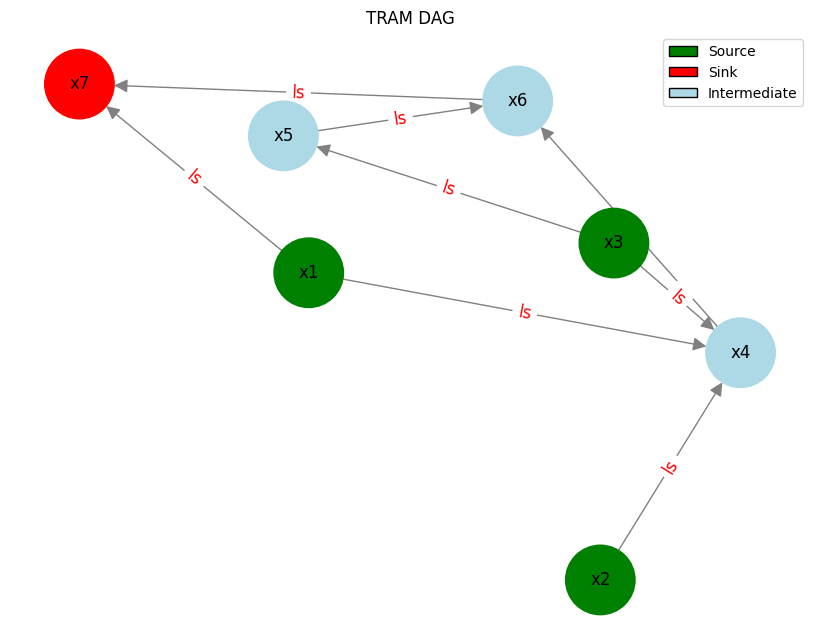

In [5]:
cfg.set_meta_adj_matrix(seed=126) #Create the (Meta) Adjacency Matrix

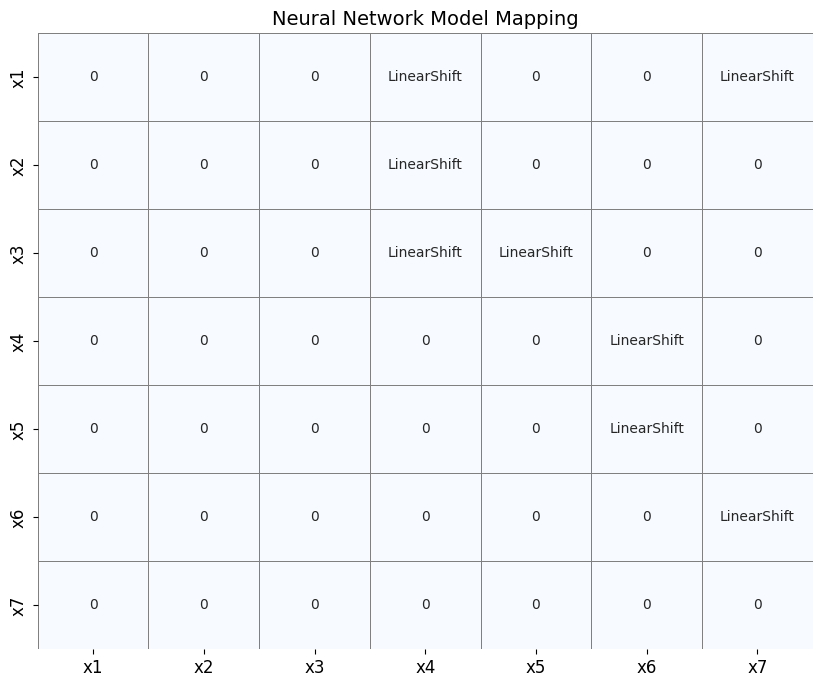

In [6]:
cfg.set_tramdag_nn_models() 


In [7]:
cfg.compute_levels(train_df)

In [8]:
from tramdag import TramDagModel
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )

In [9]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to counterf/min_max_scaling.json


In [10]:
td_model.fit(train_df, val_df,
#  train_list=['y'], #Training only on a subset of the model
    learning_rate=10e-2,
    epochs=20,batch_size=1000,
    verbose=True,debug=False,
    device=device,
    num_workers = 8,
    persistent_workers = True,
    prefetch_factor = 8,       #For DataLoader
    train_mode = "sequential") #Parallel is better for many nodes

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to counterf/min_max_scaling.json
[INFO] Training 7 nodes (sequential) on cpu

[INFO] Training node 'x1' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x3' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x4' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x5' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x6' for 20 epochs on cpu (pid=532923)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training 

In [11]:
sub = test_df.sample(n=3, random_state=42)
sub

,x1,x2,x3,x4,x5,x6,x7
365,-1.179758,1,0,2.641231,2,0.555679,2
583,-0.785529,1,2,2.093742,2,2.228381,0
879,0.217020,1,1,0.765792,3,0.809336,2


In [12]:
u_df = td_model.get_latent(sub)

[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.int64(1)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x5' has 2 unique values, expected 4. Skipping strict comparison.
[WARNING] Ordinal 'x5' has 2 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.int64(2), np.int64(3)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 2 unique values, expected 4. Skipping strict comparison.
[WARNING] Ordinal 'x7' has 2 unique values, expected 5. Skipping strict comparison.
[INFO] Final latent DataFrame shape: (3, 18)


In [13]:
u_df

,x1,x1_U,x2,x2_U_lower,x2_U_upper,x3,x3_U_lower,x3_U_upper,x4,x4_U,x5,x5_U_lower,x5_U_upper,x6,x6_U,x7,x7_U_lower,x7_U_upper
365,-1.179758,-0.139091,1,-0.173118,inf,0,-inf,-0.790524,2.641231,1.165251,2,-0.269270,0.920036,0.555679,-0.152621,2,-0.679725,0.346557
583,-0.785529,0.106239,1,-0.173118,inf,2,0.631984,inf,2.093742,0.784702,2,0.095156,1.284462,2.228381,0.806127,0,-inf,-1.934200
879,0.217020,0.742694,1,-0.173118,inf,1,-0.790524,0.631984,0.765792,-0.160540,3,1.453706,inf,0.809336,-0.176984,2,-0.858516,0.167767


In [14]:
# TODO FIX THE CONTINOUS SAMPLING

samples, latents = td_model.sample(predefined_latent_samples_df=u_df,number_of_counterfactual_samples=100)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 3
[INFO] Deleting all previously sampled data.
Deleted directory: counterf/x1/sampling
Deleted directory: counterf/x2/sampling
Deleted directory: counterf/x3/sampling
Deleted directory: counterf/x4/sampling
Deleted directory: counterf/x5/sampling
Deleted directory: counterf/x6/sampling
Deleted directory: counterf/x7/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 871.58it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Detected 'x2_U_lower' and 'x2_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x2: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x3: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x4 from dataframe column: x4_U


Sampling x4:   0%|          | 0/3 [00:00<?, ?it/s]

df_rep_i head  0
         x1   x2   x3
0 -1.179757  1.0  0.0
1 -1.179757  1.0  0.0
2 -1.179757  1.0  0.0
3 -1.179757  1.0  0.0
4 -1.179757  1.0  0.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


[INFO] Chandrupatla root finding ->  iterations::  20%|██        | 20/100 [00:00<00:00, 260.03it/s]
Sampling x4:  33%|███▎      | 1/3 [00:00<00:00,  3.34it/s]

df_rep_i head  1
        x1   x2   x3
0 -0.78553  1.0  2.0
1 -0.78553  1.0  2.0
2 -0.78553  1.0  2.0
3 -0.78553  1.0  2.0
4 -0.78553  1.0  2.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(2.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4:  67%|██████▋   | 2/3 [00:00<00:00,  2.03it/s]

df_rep_i head  2
         x1   x2   x3
0  0.217015  1.0  1.0
1  0.217015  1.0  1.0
2  0.217015  1.0  1.0
3  0.217015  1.0  1.0
4  0.217015  1.0  1.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(1.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


[INFO] Completed sampling for node 'x4'

----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
[INFO] Detected 'x5_U_lower' and 'x5_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x5:   0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  33%|███▎      | 1/3 [00:00<00:00,  5.91it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(2.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  67%|██████▋   | 2/3 [00:00<00:00,  5.63it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(1.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


[INFO] Completed sampling for node 'x5'

----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x6 from dataframe column: x6_U


Sampling x6:   0%|          | 0/3 [00:00<?, ?it/s]

df_rep_i head  0
   DUMMY        x4   x5
0    0.0  2.641224  2.0
1    0.0  2.641224  2.0
2    0.0  2.641224  2.0
3    0.0  2.641224  2.0
4    0.0  2.641224  2.0
[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(2.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x6:  33%|███▎      | 1/3 [00:00<00:01,  1.61it/s]

df_rep_i head  1
   DUMMY        x4   x5
0    0.0  2.093737  2.0
1    0.0  2.093737  2.0
2    0.0  2.093737  2.0
3    0.0  2.093737  2.0
4    0.0  2.093737  2.0
[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(2.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x6:  67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

df_rep_i head  2
   DUMMY        x4   x5
0    0.0  0.765791  3.0
1    0.0  0.765791  3.0
2    0.0  0.765791  3.0
3    0.0  0.765791  3.0
4    0.0  0.765791  3.0
[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(3.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x6: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


[INFO] Completed sampling for node 'x6'

----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
[INFO] Detected 'x7_U_lower' and 'x7_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x7: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

[INFO] Completed sampling for node 'x7'
[INFO] DAG sampling completed successfully for all nodes.


In [15]:
samples

{'x1': tensor([-1.1798, -0.7855,  0.2170]),
 'x2': tensor([[0., 1.],
         [0., 1.],
         [0., 1.]]),
 'x3': tensor([[1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.]]),
 'x4': {'vals': tensor([[2.6412],
          [2.0937],
          [0.7658]]),
  'counts': tensor([[1000],
          [1000],
          [1000]])},
 'x5': tensor([[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
 'x6': {'vals': tensor([[0.5557],
          [2.2284],
          [0.8093]]),
  'counts': tensor([[1000],
          [1000],
          [1000]])},
 'x7': tensor([[0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.]])}

In [16]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_df,do_interventions={'x3':2},number_of_counterfactual_samples=100)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['x3']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 3
[INFO] Deleting all previously sampled data.
Deleted directory: counterf/x1/sampling
Deleted directory: counterf/x2/sampling
Deleted directory: counterf/x3/sampling
Deleted directory: counterf/x4/sampling
Deleted directory: counterf/x5/sampling
Deleted directory: counterf/x6/sampling
Deleted directory: counterf/x7/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 954.86it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Detected 'x2_U_lower' and 'x2_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x2: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x3' with value 2
[INFO] Interventional data for node x3 is saved

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x4 from dataframe column: x4_U


Sampling x4:   0%|          | 0/3 [00:00<?, ?it/s]

df_rep_i head  0
         x1   x3   x2
0 -1.179757  2.0  1.0
1 -1.179757  2.0  1.0
2 -1.179757  2.0  1.0
3 -1.179757  2.0  1.0
4 -1.179757  2.0  1.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(2.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4:  33%|███▎      | 1/3 [00:00<00:01,  1.86it/s]

df_rep_i head  1
        x1   x3   x2
0 -0.78553  2.0  1.0
1 -0.78553  2.0  1.0
2 -0.78553  2.0  1.0
3 -0.78553  2.0  1.0
4 -0.78553  2.0  1.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(2.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4:  67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]

df_rep_i head  2
         x1   x3   x2
0  0.217015  2.0  1.0
1  0.217015  2.0  1.0
2  0.217015  2.0  1.0
3  0.217015  2.0  1.0
4  0.217015  2.0  1.0
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(2.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


[INFO] Chandrupatla root finding ->  iterations::  10%|█         | 10/100 [00:00<00:00, 273.17it/s]
Sampling x4: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


[INFO] Completed sampling for node 'x4'

----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
[INFO] Detected 'x5_U_lower' and 'x5_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x5:   0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.int64(2)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  33%|███▎      | 1/3 [00:00<00:00,  4.53it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.int64(2)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.int64(2)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


[INFO] Completed sampling for node 'x5'

----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x6 from dataframe column: x6_U


Sampling x6:   0%|          | 0/3 [00:00<?, ?it/s]

df_rep_i head  0
   DUMMY        x4   x5
0    0.0  2.605946  1.0
1    0.0  2.605946  2.0
2    0.0  2.605946  1.0
3    0.0  2.605946  2.0
4    0.0  2.605946  2.0
[WARNING] Ordinal 'x5' has 2 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(1.0), np.float64(2.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 2 unique values, expected 4. Skipping strict comparison.


Sampling x6:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

df_rep_i head  1
   DUMMY        x4   x5
0    0.0  2.093737  2.0
1    0.0  2.093737  2.0
2    0.0  2.093737  2.0
3    0.0  2.093737  2.0
4    0.0  2.093737  2.0
[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(2.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x6:  67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

df_rep_i head  2
   DUMMY        x4   x5
0    0.0  0.690629  3.0
1    0.0  0.690629  3.0
2    0.0  0.690629  3.0
3    0.0  0.690629  3.0
4    0.0  0.690629  3.0
[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(3.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x6: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


[INFO] Completed sampling for node 'x6'

----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
[INFO] Detected 'x7_U_lower' and 'x7_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x7: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

[INFO] Completed sampling for node 'x7'
[INFO] DAG sampling completed successfully for all nodes.


In [17]:
samples

{'x1': tensor([-1.1798, -0.7855,  0.2170]),
 'x2': tensor([[0., 1.],
         [0., 1.],
         [0., 1.]]),
 'x3': tensor([2, 2, 2]),
 'x4': {'vals': tensor([[2.6059],
          [2.0937],
          [0.6906]]),
  'counts': tensor([[1000],
          [1000],
          [1000]])},
 'x5': tensor([[0.0000, 0.3010, 0.6990, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]),
 'x6': {'vals': tensor([[0.5552, 0.6368],
          [2.2284,    nan],
          [0.8084,    nan]]),
  'counts': tensor([[ 699,  301],
          [1000,    0],
          [1000,    0]])},
 'x7': tensor([[0.0000, 0.0000, 0.9940, 0.0060, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0010, 0.9990, 0.0000, 0.0000]])}